# Introduction

In this notebook, we will use data from [here](http://data.princeton.edu/wws509/datasets/#salary), in which we want to see whether there's discrimination in professor salaries or not.

In [1]:
import pymc3 as pm
import pandas as pd
import theano.tensor as tt
import numpy as np

%matplotlib inline

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


## Problem Type

This is standard linear regression! To those who have been trained in stats, this shouldn't be too difficult to understand. 



## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement.
- The columns should indicate, at the minimum:
    - The explanatory variables, each getting their own column.
    - The dependent variable, one column.

## Extensions to the model

None

## Reporting summarized findings

Here are examples of how to summarize the findings.

> For every unit increase in `explanatory_variable_i`, dependent variable increases by `beta` (95% HPD: [`lower`, `upper`]).

## Other notes

None

The data are from [here][datasource], and have the following columns:

Independent variables:

- `sx`: the biological sex of the professor.
    - 0 for male
    - 1 for female
- `rk`: the rank of the professor.
    - 1 for assistant professor
    - 2 for associate professor
    - 3 for full professor
- `dg`: the highest degree attained
    - 0 for masters degree
    - 1 for doctorate degre
- `yd`: years since degree obtained. Essentially an 'experience' term.

Dependent variables:

- `sl`: annual salary

[datasource]: http://data.princeton.edu/wws509/datasets/#salary

# Read Data

Let's read in the data and do some preprocessing to make all of the data numerical.

In [2]:
# Read in the data
df = pd.read_csv('datasets/professor-salary.txt')

def replace_sx(sex):
    """
    This function codes the biological sex of the professor.
    """
    if sex == 'male':
        return 0
    elif sex == 'female':
        return 1
    
def replace_rk(rank):
    """
    This function codes the highest rank attained.
    """
    if rank == 'full':
        return 3
    elif rank == 'associate':
        return 2
    elif rank == 'assistant':
        return 1
    
def replace_dg(degree):
    """
    This function codes the highest degree earned.
    """
    if degree == 'doctorate':
        return 1
    elif degree == 'masters':
        return 0

# Perform variable numerical encoding.
df['sx'] = df['sx'].apply(lambda x: replace_sx(x))
df['rk'] = df['rk'].apply(lambda x: replace_rk(x))
df['dg'] = df['dg'].apply(lambda x: replace_dg(x))

# Preview the data
# import patsy
X = df[['sx', 'rk', 'yr', 'dg', 'yd']]
# X = patsy.dmatrix('sx + rk + yr + dg + yd -1', X, return_type='dataframe')
Y = df['sl']

# Model

We will perform linear regression on the salary data. Here's some of the modelling choices that go into this.

1. Choice of priors:
    1. Intercept: Normal distribution. Very wide.
    1. Errors: Can only be positive, therefore use HalfNormal distribution, again, very wide.
1. Choices for salary likelihood function:
    1. The salary is modelled as a linear combination of the independent variables.
    1. We assume that the salary is going to be normally distributed around the linear combination of independent variables with the same variance around the expected value.
    
That is how we get the code below.

In [3]:
from sklearn.preprocessing import normalize
# X = pm.floatX(X)
# df.columns = ['sx', 'rk', 'yr', 'dg', 'yd', 'sl']

In [4]:
import numpy as np
import theano.tensor as tt

with pm.Model() as model:

#     intercept = pm.Normal('intercept', mu=0, sd=100**2)
#     error = pm.HalfNormal('error', sd=100**2)

#     b = pm.Normal('betas', mu=0, sd=100**2, shape=(X.shape[1], 1))
#     sl = tt.dot(X, b) + intercept
    
#     sl_like = pm.Normal('likelihood', mu=sl, sd=error, observed=Y)

    pm.glm.linear.GLM(X, Y)

With the recipe above, you'll have a general starting point for linear regressions (and its variants, e.g. poisson regression). The key idea, which you'll see later on, is swapping out the likelihood function.

The awesome PyMC3 developers provide also a GLM module that lets you write the above more concisely:

```python
with pm.Model() as model:
    pm.glm.glm('sl ~ sx + rk + yr + dg + yd', df)
```

However, I have given you the more verbose version, as I want you to see the code at the level of abstraction that will let you flexibly modify the model as you need it.

Borrowing shamelessly from Thomas Wiecki, we hit the Inference Button (TM) below.

In [5]:
with model:
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 630.83:  19%|█▉        | 38425/200000 [00:16<01:09, 2331.43it/s]    
Convergence archived at 38500
Interrupted at 38,500 [19%]: Average Loss = 1.8269e+09
100%|██████████| 2500/2500 [00:17<00:00, 140.33it/s]


Let's visualize the traceplots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f576c89c278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f576c414d30>]], dtype=object)

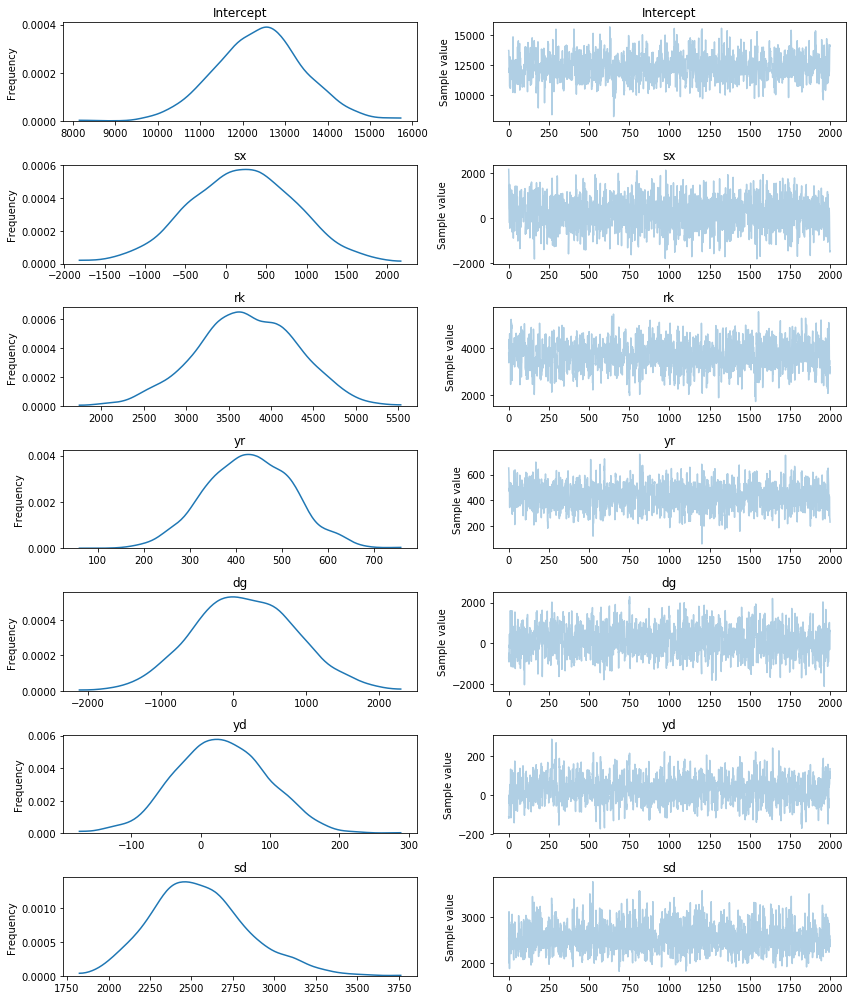

In [6]:
pm.traceplot(trace)

The traceplots give us a visual diagnostic on the convergence of the MCMC sampler. The ADVI initialization gets us pretty darn close to the places of highest likelihood. Sampling converges pretty soon after, so let's use a **burn-in** of ~1000 steps and re-check.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f576b1429b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f576dea7400>]], dtype=object)

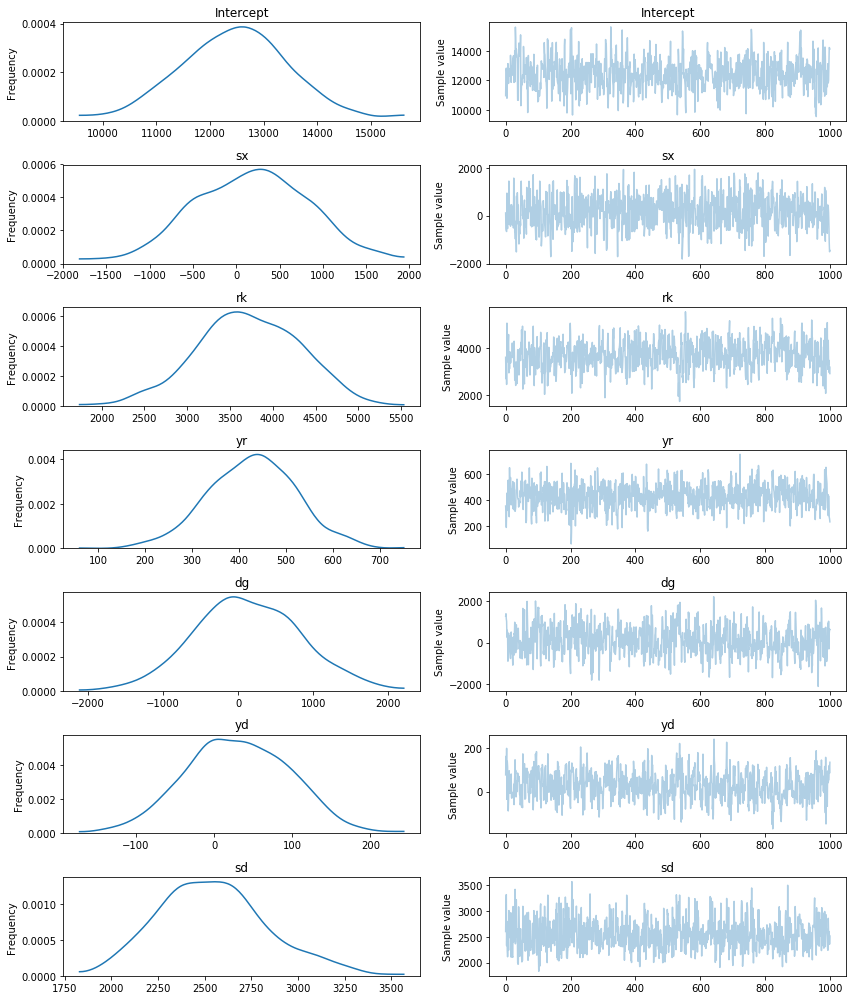

In [7]:
burnin = 1000
pm.traceplot(trace[burnin:])

Should be pretty clear - very good convergence. Let's look at a forestplot of the inferred variables.

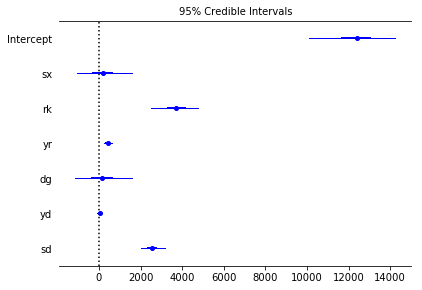

In [8]:
pm.forestplot(trace)

In [9]:
def get_percs(varname):
    return np.round(np.percentile(trace[varname], [2.5, 50, 97.5]), 0)

intercept_percs = get_percs('Intercept')
sex_percs = get_percs('sx')
year_percs = get_percs('yr')
rank_percs = get_percs('rk')
degree_percs = get_percs('dg')
experience_percs = get_percs('yd')
sd_percs = get_percs('sd')

# Interpretation

The interpretation here is as such. 

Given the data on hand, 

- a professor's baseline salary is in the range of \${{ intercept_percs[0] }} to \${{ intercept_percs[2] }} dollars
- every increase in rank gives \${{rank_percs[0]}} to \${{rank_percs[2]}} dollars increase in salary
- females earn \${{sex_percs[0]}} to \${{sex_percs[2]}} more dollars than males
- every extra year of work earns the professor \${{year_percs[0]}} to \${{year_percs[2]}} in salary
- having an advanced degree earns the professor \${{degree_percs[0]}} to \${{degree_percs[2]}} in salary
- every year away from the degree earned earns the professor \${{experience_percs[0]}} to \${{experience_percs[2]}} in salary.

# Conclusions
Overall, rank and years of work are the best predictors of professor salary.